# Linear Regression for Song Prediction (Continuous) and Classification

First we need to import out necessary libraries and datasets

In [7]:
# General Math
import numpy as np
import pandas as pd

# Dataset
import kagglehub
from kagglehub import KaggleDatasetAdapter

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # NOTE: imblearn Pipeline (not sklearn)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

# Visualization
import seaborn as sbn
sbn.set_style("whitegrid")
from matplotlib import pyplot as plt


In [8]:
# Downloading the latest version of the dataset
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")

print("Path to dataset files:", path)


Path to dataset files: /Users/carson_nov_2025/.cache/kagglehub/datasets/maharshipandya/-spotify-tracks-dataset/versions/1


In [9]:
df = pd.read_csv(path + '/dataset.csv')
df = df.drop(df.columns[0], axis=1)
df.head()

track_id                 artists  \
0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610    1    -6.746     0       0.1430        0.0322   
1         0.420  0.1660    1   -17.235     1       0.0763        0.9240   
2         0.438  0.3590    0    -9.734     1       0.0557        0.2100   
3         0.266  0.0596    0   -18.515     1       0.0363        0.9050   
4         0.618  0.4430    2    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature track_genre  
0          0.000001    0.3580    0.715   87.917               4    acoustic  
1          0.000006    0.1010    0.267   77.489               4    acoustic  
2          0.000000    0.1170    0.120   76.332               4    acoustic  
3          0.000071    0.1320    0.143  181.740               3    acoustic  
4          0.000000    0.0829    0.167  119.949               4    acoustic

# Data Processing

We take the following steps to improve / clean up the data
1. We use a simple impute to eliminate any missing values. (This technically isn't that important because we are missing almost not data)

2. We use a Standard Scalar to normalize all of our numeric features, except for 'duration_ms' where we use a Robust Scaler because it has much more outlier data

3. We apply 1 hot encoding to the categorical features

4. Apply TargetEncoding to the 'track_genre' because of how it has thousands of categories

In [16]:
#PREPROCESSING

# Define features
numeric_features = [
    'danceability', 'energy', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo'
]

outlier_features = [
    'duration_ms', 
]

binary_features = ['explicit', 'mode']

categorical_features = ['key', 'time_signature']  # optional: add 'artists' but it's large

# Using Target Encoder to prevent us from creating thousands of buckets
categorical_large_features = ['track_genre'] # optional: add 'artists'

target = 'popularity'

# Preprocess numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

outlier_numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Preprocess binary features (no scaling needed)
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Preprocess categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

categorical_large_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('target', TargetEncoder())
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('out', outlier_numeric_transformer, outlier_features),
        ('bin', binary_transformer, binary_features),
        ('cat', categorical_transformer, categorical_features),
        ('cat_xl', categorical_large_transformer, categorical_large_features)
    ]
)

# Build full pipeline
lr_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', LinearRegression())
])

# Training the Model

In [17]:
# Train-test split
from sklearn.model_selection import train_test_split
X = df[numeric_features + outlier_features + binary_features + categorical_features + categorical_large_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
lr_model.fit(X_train, y_train)

# Predict
y_pred = lr_model.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


R²: 0.2588261569788145
MSE: 365.75512419340936


We can also use the model to do classification into two buckets: popular and not popular. This is a method measurement used by another paper, so it would be interesting to see its results. 

We are currently using a value of >= 60 to determine if a song is popular

Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.76      0.84     19836
    Positive       0.31      0.72      0.43      2964

    accuracy                           0.75     22800
   macro avg       0.63      0.74      0.64     22800
weighted avg       0.86      0.75      0.79     22800



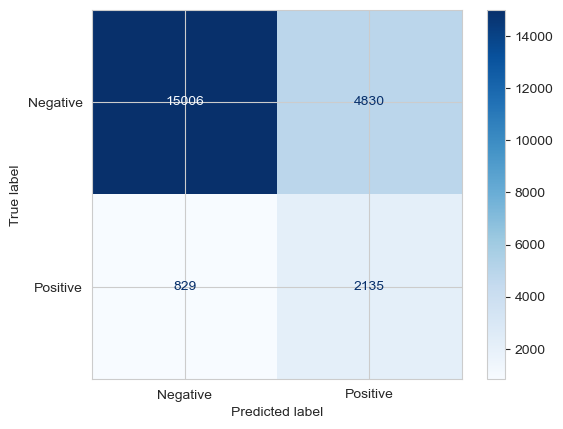

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

clf_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('regressor', LogisticRegression(max_iter=1000))
])

X_class = df[numeric_features + outlier_features + binary_features + categorical_features + categorical_large_features]
y_class = (df["popularity"] >= 60).astype(int)

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42, stratify=y_class)

clf_model.fit(X_train_class, y_train_class)

# Predict
y_pred_class = clf_model.predict(X_test_class)

report = classification_report(y_test_class, y_pred_class, target_names=['Negative', 'Positive'])
print("Classification Report:")
print(report)


res = confusion_matrix(y_test_class, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=res, display_labels=["Negative", "Positive"])

disp.plot(cmap=plt.cm.Blues)
plt.show()

For the linear regression dataset above, we can see that we literally predict everything as not popular. This is really bad. What if we lower the bar for a song being popular so the data is better split 50/50?

We can now see that we predict for songs to be both popular and unpopular, but we have a lot of false positives.

              precision    recall  f1-score   support

    Negative       0.77      0.64      0.70     10121
    Positive       0.75      0.85      0.80     12679

    accuracy                           0.76     22800
   macro avg       0.76      0.75      0.75     22800
weighted avg       0.76      0.76      0.75     22800



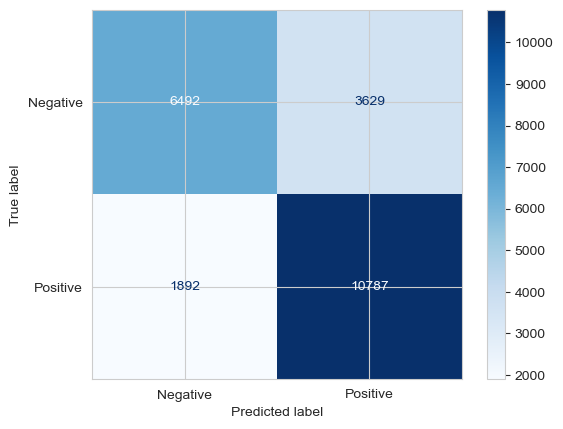

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Turn continuous data into classification data

y_pred_class = np.ones_like(y_pred)
y_test_class = np.ones_like(y_test)

y_pred_class[y_pred < 30] = 0
y_test_class[y_test < 30] = 0

report = classification_report(y_test_class, y_pred_class, target_names=['Negative', 'Positive'])
print(report)

res = confusion_matrix(y_test_class, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=res, display_labels=["Negative", "Positive"])

disp.plot(cmap=plt.cm.Blues)
plt.show()

# Visualization of Data
Below we visualize the relationship between each type of data and the songs popularity. The **red** line represents the regression line, while the **orange** line shows the general trend line.

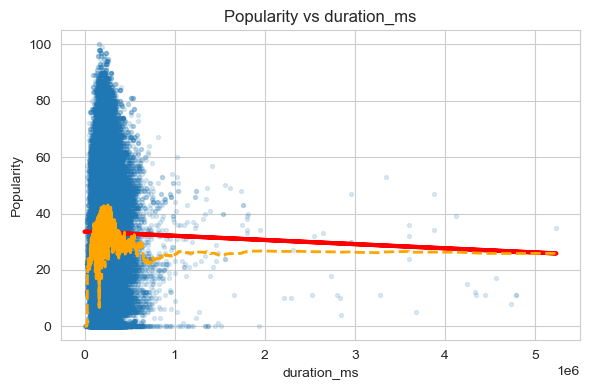

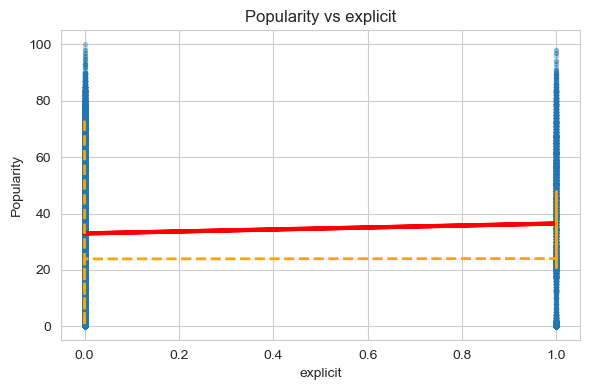

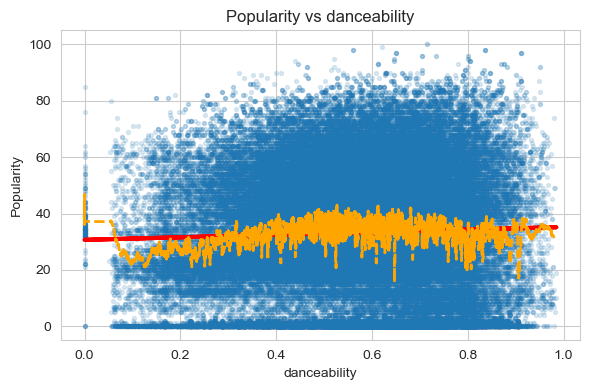

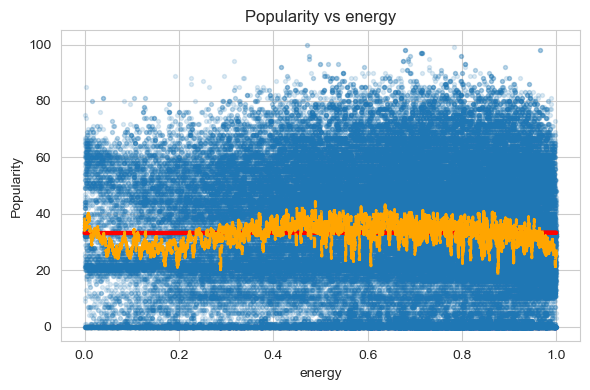

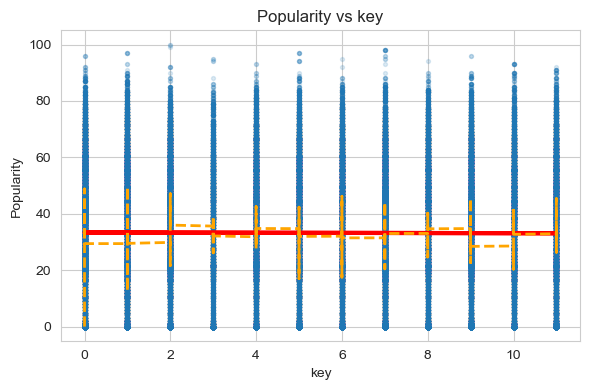

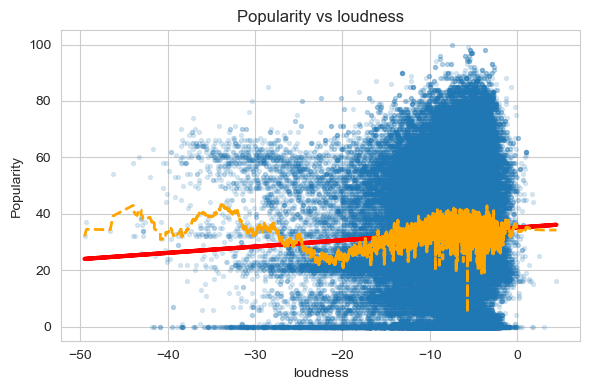

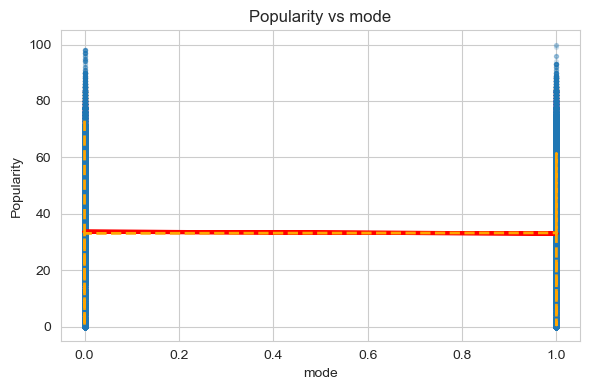

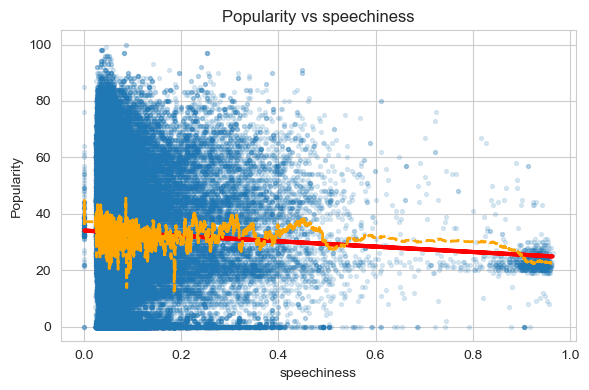

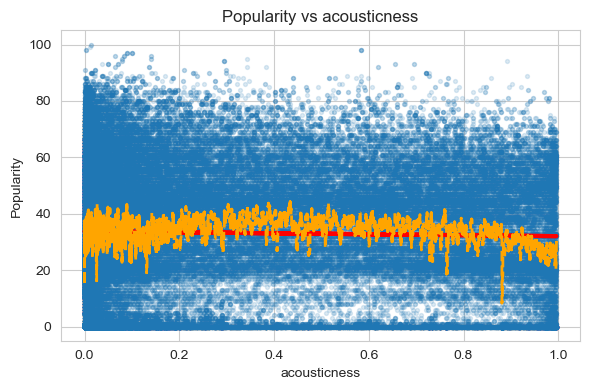

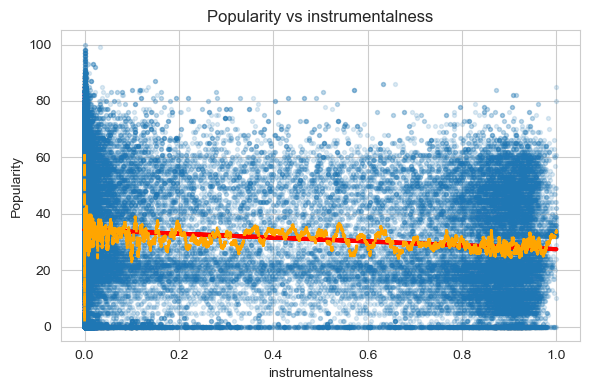

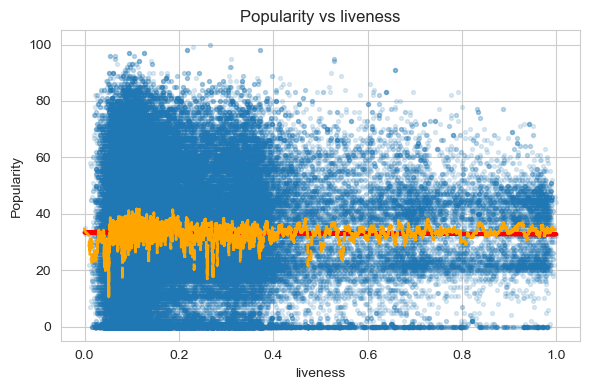

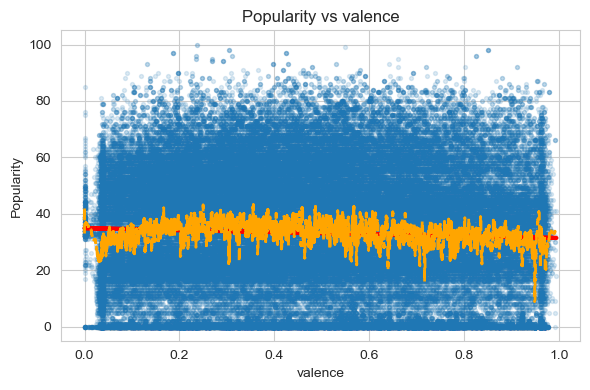

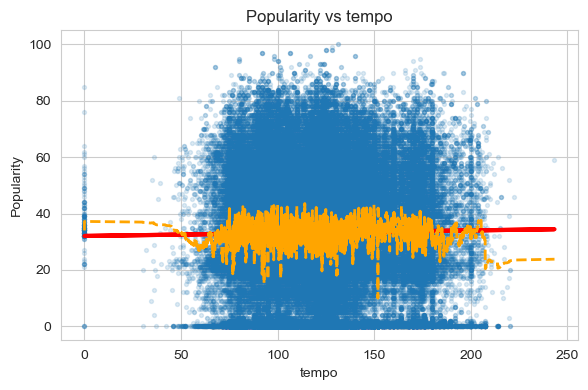

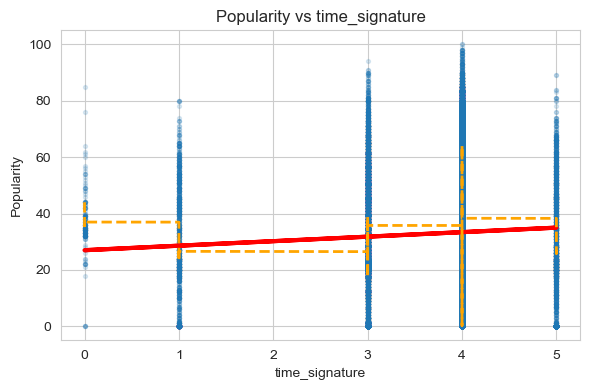

Error:  can only concatenate str (not "float") to str


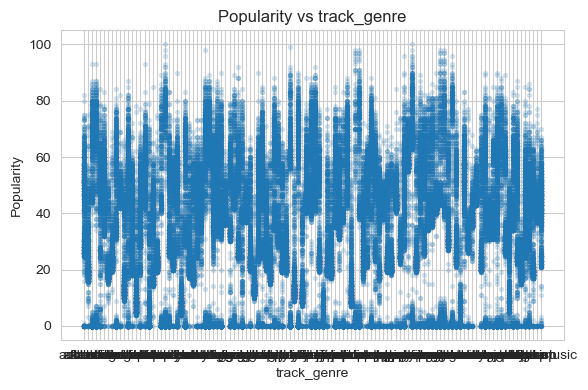

In [9]:
features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature', 'track_genre'
]

target = 'popularity'

for feature in features: 
    x = X[feature]
    plt.figure(figsize=(6,4))

    # Scatterplot (smaller + more transparent points)
    plt.scatter(x, y, s=8, alpha=0.15)

    try:
        m, b = np.polyfit(x, y, 1)
        # Regression line (thicker)
        plt.plot(x, m*x + b, linewidth=3, color='red')

         # Optional: smoothed rolling mean to show general trend
        x_sorted = np.sort(x)
        y_smooth = pd.Series(y[np.argsort(x)]).rolling(200, min_periods=1).mean()

        plt.plot(x_sorted, y_smooth, linewidth=2, linestyle="--", color="orange")

    except Exception as e:
        print("Error: ", e)

    plt.title(f"Popularity vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("Popularity")
    plt.tight_layout()
    plt.show()

# Feature Selection

If we want to shrink / simplify our data set, we can perform feature selection using a method such as lasso regression.

*this may take several minutes to run*

Additionally, you will need to refact the preprocessor to not include artists.

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python

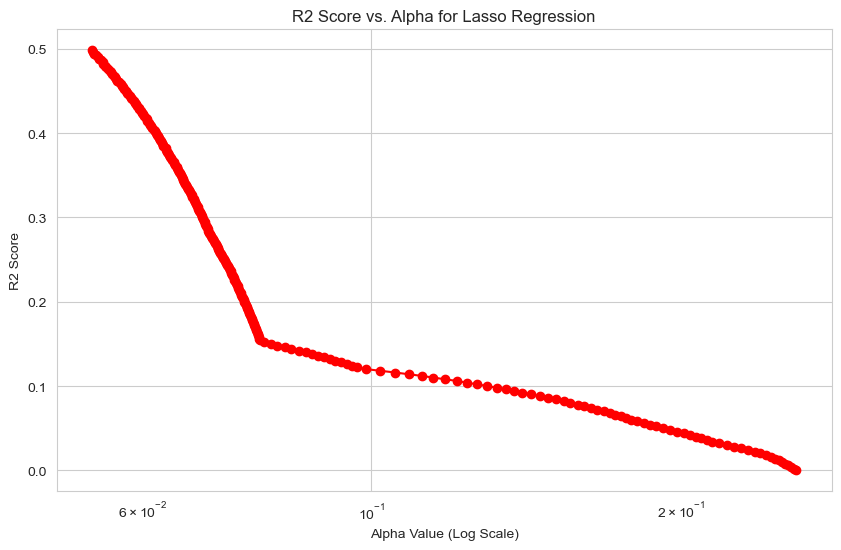

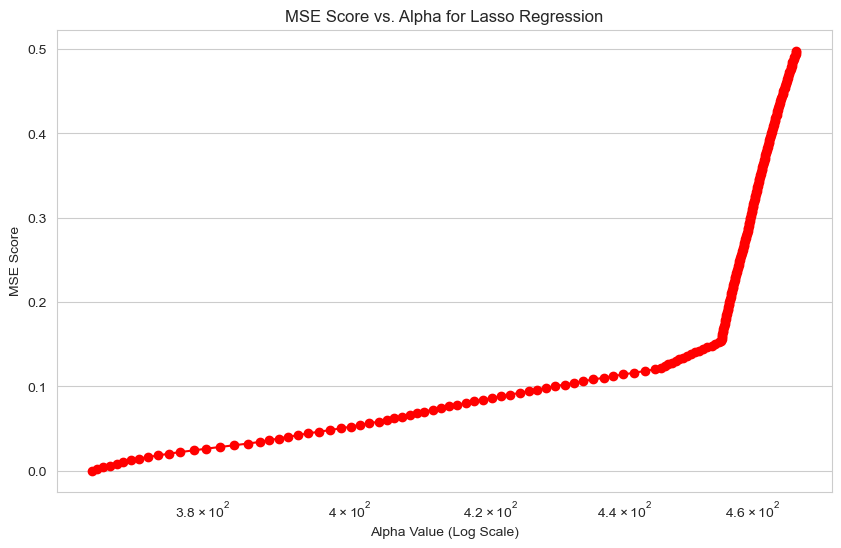

In [10]:
alpha_val = 0.0001
alpha_results = []
r2_results = []
mse_results = []
while alpha_val < 0.5:
    lasso_model = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('regressor', Lasso(alpha=alpha_val, max_iter=10000))
    ])
    lasso_model.fit(X_train, y_train)
    y_pred = lasso_model.predict(X_test)
    alpha_results.append(alpha_val)
    r2_results.append(r2_score(y_test, y_pred))
    mse_results.append(mean_squared_error(y_test, y_pred))
    alpha_val += 0.002

plt.figure(figsize=(10, 6))
plt.plot(r2_results, alpha_results, marker='o', linestyle='-', color='red')
plt.title("R2 Score vs. Alpha for Lasso Regression")
plt.xscale('log')
plt.xlabel("Alpha Value (Log Scale)")
plt.ylabel("R2 Score")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(mse_results, alpha_results, marker='o', linestyle='-', color='red')
plt.title("MSE Score vs. Alpha for Lasso Regression")
plt.xscale('log')
plt.xlabel("Alpha Value (Log Scale)")
plt.ylabel("MSE Score")
plt.show()

# Ignore Below
You can mostly ignore what is below this part

In [11]:
features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature'
]
target = 'popularity'

In [12]:
df['explicit'] = df['explicit'].astype(int)


In [13]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [15]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = model.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


R²: 0.022472781708298806
MSE: 482.39099705856654


In [16]:
coef_df = pd.DataFrame({
    "feature": features,
    "coef": model.coef_
}).sort_values(by="coef", ascending=False)

print(coef_df)


             feature       coef
2       danceability   7.985637
1           explicit   3.520068
10          liveness   1.567495
13    time_signature   1.086070
5           loudness   0.104541
12             tempo   0.014846
0        duration_ms  -0.000002
4                key  -0.015538
6               mode  -0.746277
8       acousticness  -1.091095
3             energy  -3.173038
9   instrumentalness  -8.061867
11           valence  -9.468126
7        speechiness -15.126554


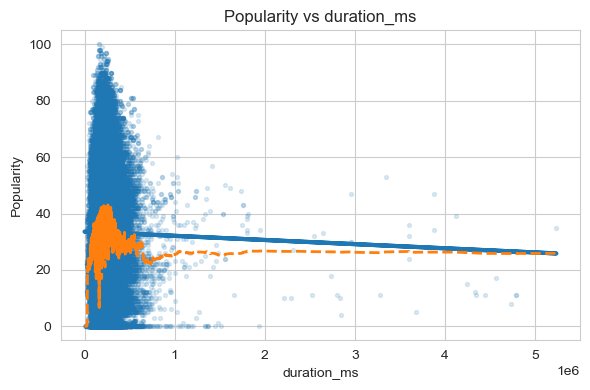

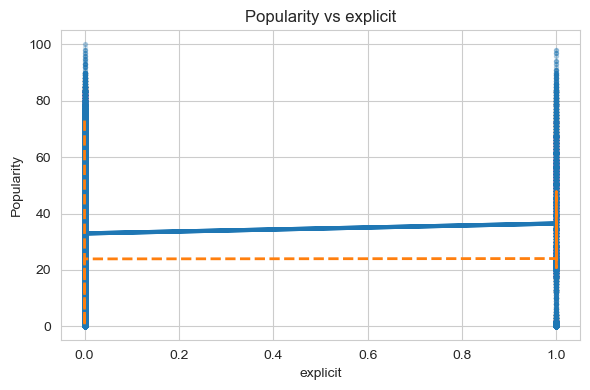

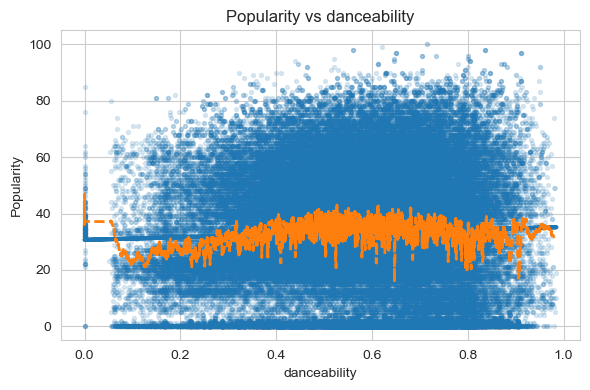

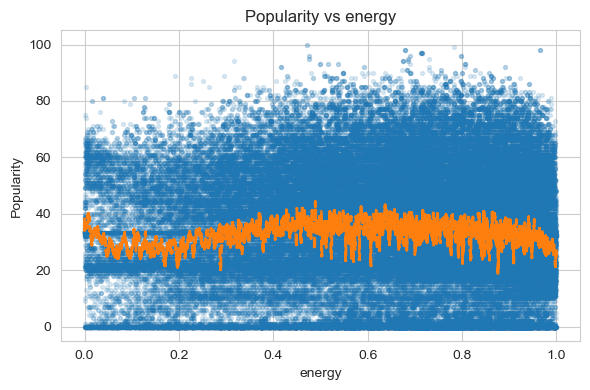

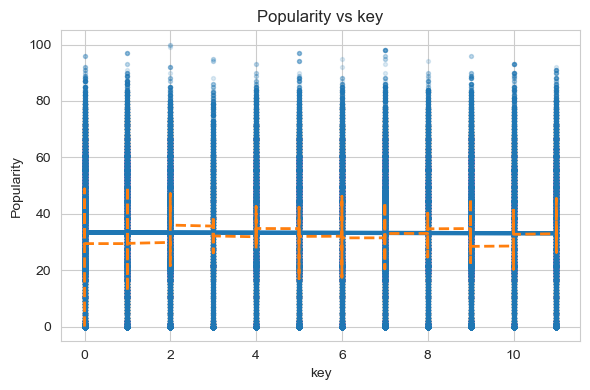

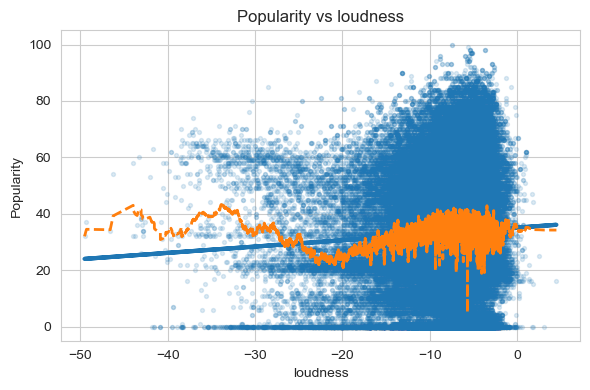

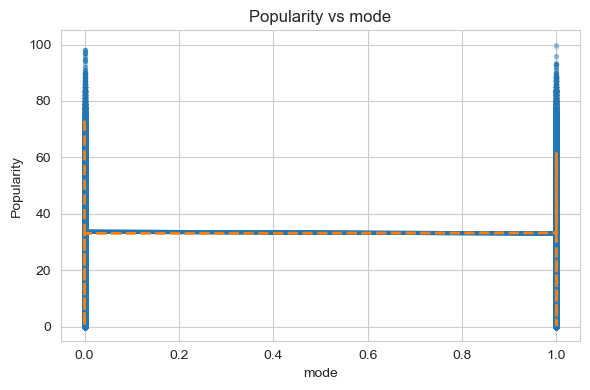

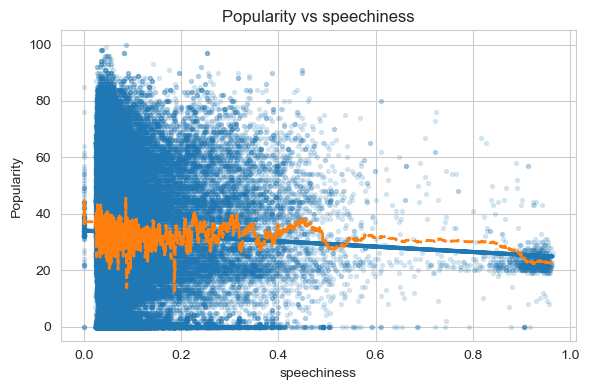

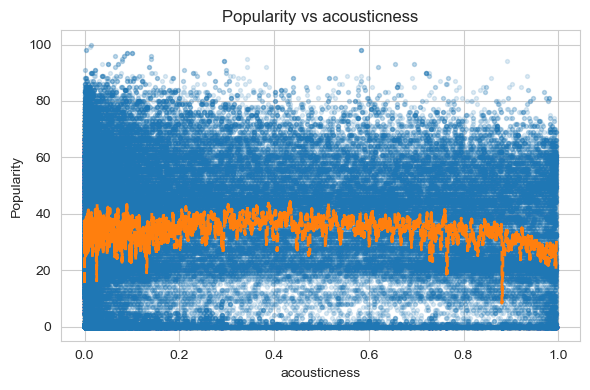

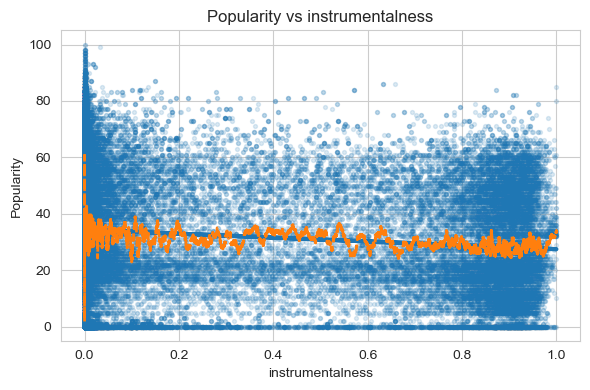

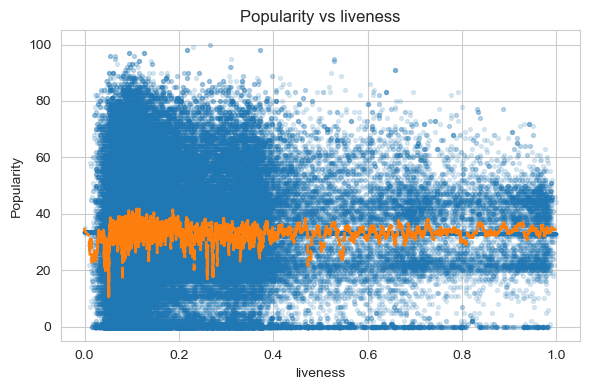

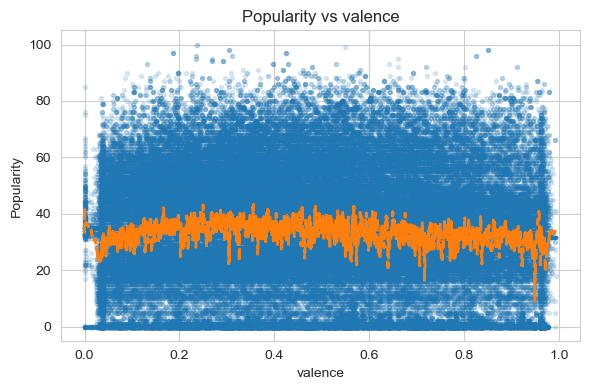

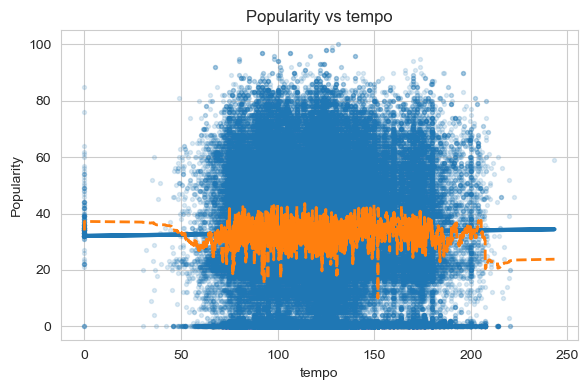

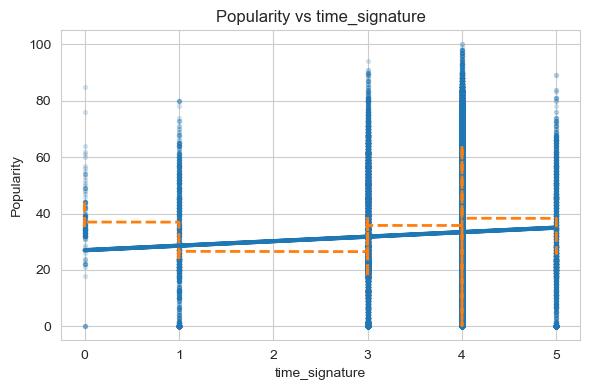

In [17]:
import numpy as np
import matplotlib.pyplot as plt

for feature in features:
    x = df[feature]
    y = df[target]

    # Fit linear regression using numpy
    m, b = np.polyfit(x, y, 1)

    plt.figure(figsize=(6,4))

    # Scatterplot (smaller + more transparent points)
    plt.scatter(x, y, s=8, alpha=0.15)

    # Regression line (thicker)
    plt.plot(x, m*x + b, linewidth=3)

    # Optional: smoothed rolling mean to show general trend
    x_sorted = np.sort(x)
    y_smooth = pd.Series(y[np.argsort(x)]).rolling(200, min_periods=1).mean()

    plt.plot(x_sorted, y_smooth, linewidth=2, linestyle="--")


    plt.title(f"Popularity vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("Popularity")
    plt.tight_layout()
    plt.show()
